In [1]:
import logging
import numpy as np
import pandas as pd
from arch import arch_model
from random import gauss
from random import seed
from matplotlib import pyplot as plt
import scipy.stats as sts
import json
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.optimize import least_squares
import os

In [2]:
os.chdir(os.getcwd() + '/..')

In [149]:
from rules_related import combine_rules_outputs
from whole_algorithm import train_model
from auxiliary import calc_log_returns, unpack_1d_parameters
from multivariate_normal_distribution import LongMultivariateNormal
from model import FuzzyVolatilityModel
from membership_functions import calc_trapezoidal_membership_degrees
from clusterization.all_methods import cluster_data_1d, cluster_data
# from membership_functions.trapezoidal import _calc_trapezoidal_md_scalar

In [4]:
with open('config.json') as file:
    config = json.load(file)

In [5]:
files_folder = config['files_folders']['processed']
logs_folder = config['files_folders']['logs']

In [6]:
logging.basicConfig(level=logging.DEBUG,
                    filename=f'{logs_folder}/seasonal_testing.log',
                    filemode='w',
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S')

# Reading files

In [7]:
rtsi = pd.read_pickle(f'{files_folder}/rtsi.pkl')

In [8]:
rtsi

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,return,log return
<DATE>,,,,,,,
2001-02-18,180.10,180.10,180.10,180.10,0,0.000000,0.000000
2001-02-19,180.10,181.21,176.67,177.29,0,-0.015602,-0.015725
2001-02-20,177.29,179.90,175.28,176.45,0,-0.004738,-0.004749
2001-02-21,176.45,176.45,161.12,162.39,0,-0.079683,-0.083037
2001-02-22,162.39,168.35,162.39,168.31,0,0.036455,0.035807
...,...,...,...,...,...,...,...
2021-10-11,1871.73,1883.71,1867.58,1882.43,1769145502,0.011537,0.011471
2021-10-12,1867.15,1876.79,1860.64,1869.94,1386130631,-0.006635,-0.006657
2021-10-13,1869.05,1869.05,1835.80,1855.11,1830447018,-0.007931,-0.007962


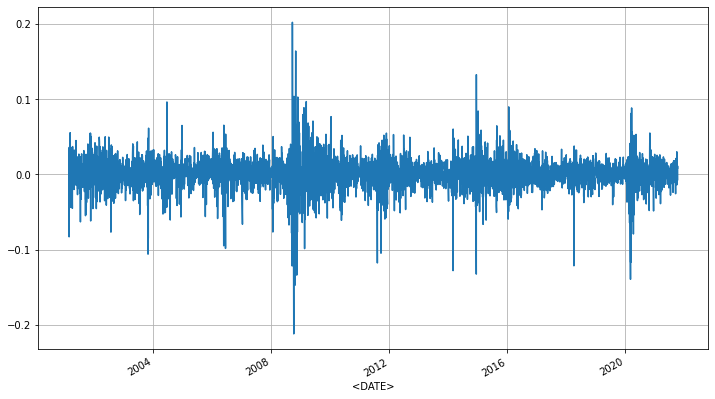

In [9]:
rtsi['log return'].plot(figsize=(12, 7))

plt.grid()
plt.show()

In [10]:
rtsi['log return'].describe()

count    5174.000000
mean        0.000455
std         0.020327
min        -0.211994
25%        -0.008822
50%         0.001318
75%         0.010414
max         0.202039
Name: log return, dtype: float64

In [11]:
rtsi['day of week'] = rtsi.index.dayofweek + 1

In [12]:
rtsi['day of week']

<DATE>
2001-02-18    7
2001-02-19    1
2001-02-20    2
2001-02-21    3
2001-02-22    4
             ..
2021-10-11    1
2021-10-12    2
2021-10-13    3
2021-10-14    4
2021-10-15    5
Name: day of week, Length: 5174, dtype: int64

In [13]:
# rtsi['test triangular cluster memb'] = \
calc_trapezoidal_membership_degrees(rtsi['day of week'].values,
                                    a=[0, 2],
                                    b=[2, 4],
                                    c=[2, 4],
                                    d=[4, 6])

array([0., 0.])

# Setting data & parameters

In [14]:
rescale_factor = 100

In [15]:
start_date = '2010-01-01'

In [16]:
input_data = rtsi['log return'].loc[start_date:].copy() * rescale_factor

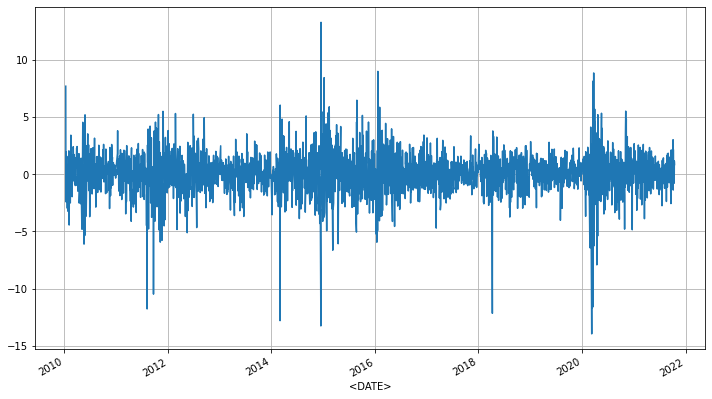

In [17]:
input_data.plot(figsize=(12, 7))

plt.grid()
plt.show()

In [18]:
input_data.describe()

count    2965.000000
mean        0.009091
std         1.772184
min       -13.948614
25%        -0.867805
50%         0.060068
75%         0.920911
max        13.246192
Name: log return, dtype: float64

In [19]:
n = input_data.shape[0]

In [20]:
n

2965

In [21]:
input_data.index.dayofweek + 1

Int64Index([1, 2, 3, 4, 5, 1, 2, 3, 4, 5,
            ...
            1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
           dtype='int64', name='<DATE>', length=2965)

## Train / test split

In [22]:
n_train = 100  # 2000

n_test = 10
n_test = min(n - n_train, n_test)

In [23]:
train, test = input_data.iloc[:n_train].copy(), input_data.iloc[n_train:(n_train + n_test)].copy()
input_cut = pd.concat([train, test]).copy()
# data_to_cluster_train, data_to_cluster_test = days_of_week.iloc[:n_train].copy(), days_of_week.iloc[n_train:].copy()

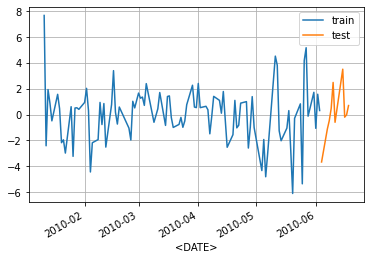

In [24]:
train.plot(label='train')
test.plot(label='test')

plt.legend()
plt.grid()
plt.show()

In [25]:
train.describe()

count    100.000000
mean      -0.033298
std        2.141924
min       -6.113558
25%       -1.051010
50%        0.314542
75%        1.041423
max        7.668616
Name: log return, dtype: float64

## Antecedent parameters

In [26]:
# set #1
clusterization_method_1 = 'trapezoidal'

n_clusters_1 = 2

a = [1, 1]
b = [1, 5]
c = [1, 5]
d = [5, 5]

# set #2
clusterization_method_2 = 'gaussian'

n_clusters_2 = 2

# variances = [7, 6, 3, 5]
# centers = [-7.5, -1.5, 1.5, 4]
variances = [7, 5]
centers = [-4.5, 2.5]

In [27]:
# rtsi['test triangular cluster memb'] = \
calc_trapezoidal_membership_degrees(2,
                                    a=a,
                                    b=b,
                                    c=c,
                                    d=d)

array([0.75, 0.25])

In [28]:
clusterization_parameters = [{'a': a, 'b': b, 'c': c, 'd': d, 'n_clusters': n_clusters_1},
                             {'centers': centers, 'variances': variances, 'n_clusters': n_clusters_2}]
clusterization_methods = [clusterization_method_1, clusterization_method_2]
n_clusters = n_clusters_1 * n_clusters_2

## Consequent parameters

In [29]:
# technical parameters for arch_model function
garch_mean = 'Zero'
garch_dist = 'normal'

# general parameters
local_method = 'garch'

# GARCH parameters
p = 1
q = 1

starting_index = max(p, q)

train_sample_std = train.std()
first_h = [train_sample_std ** 2] * starting_index
first_h = np.array(first_h)

# parameters constraints
lower_bounds = [0] * (1 + p + q) * n_clusters
upper_bounds = [+np.inf] * n_clusters + [1] * (p + q) * n_clusters
bounds = (lower_bounds, upper_bounds)

### Using classic GARCH to get initial parameters values

In [30]:
garch = arch_model(train,
                   mean=garch_mean,
                   vol='GARCH',
                   p=p,
                   q=q,
                   dist=garch_dist)
garch_fitted = garch.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 299.2568988057981
Iteration:      2,   Func. Count:     11,   Neg. LLF: 218.16618783247299
Iteration:      3,   Func. Count:     19,   Neg. LLF: 216.13038589493937
Iteration:      4,   Func. Count:     25,   Neg. LLF: 210.3506174261232
Iteration:      5,   Func. Count:     30,   Neg. LLF: 210.03006916424286
Iteration:      6,   Func. Count:     34,   Neg. LLF: 210.02991627546388
Iteration:      7,   Func. Count:     38,   Neg. LLF: 210.02991515111927
Iteration:      8,   Func. Count:     41,   Neg. LLF: 210.0299151508097
Optimization terminated successfully    (Exit mode 0)
            Current function value: 210.02991515111927
            Iterations: 8
            Function evaluations: 41
            Gradient evaluations: 8


In [31]:
garch_fitted.params

omega       0.176520
alpha[1]    0.116376
beta[1]     0.836795
Name: params, dtype: float64

In [32]:
alpha_0_ini = np.array([garch_fitted.params.iloc[0] for _ in range(n_clusters)])
alpha_ini = np.array([garch_fitted.params.iloc[1:(q + 1)].values for _ in range(n_clusters)])
beta_ini = np.array([garch_fitted.params.iloc[(q + 1):].values for _ in range(n_clusters)])

In [33]:
# alpha_0_ini, alpha_ini, beta_ini = unpack_1d_parameters(garch_fitted.params.values, p=p, q=q, n_clusters=n_clusters)

In [34]:
parameters_ini = {'alpha_0': alpha_0_ini, 'alpha': alpha_ini, 'beta': beta_ini}

In [35]:
parameters_ini

{'alpha_0': array([0.17652034, 0.17652034, 0.17652034, 0.17652034]),
 'alpha': array([[0.11637558],
        [0.11637558],
        [0.11637558],
        [0.11637558]]),
 'beta': array([[0.8367954],
        [0.8367954],
        [0.8367954],
        [0.8367954]])}

In [36]:
# # initial parameters values for LS to start with
# alpha_0_ini = np.array([garch_fitted.params.loc['omega']] * n_clusters)
# alpha_ini = np.array([[1] * n_clusters] * q)
# beta_ini = np.array([[1] * n_clusters] * p)
# parameters_ini = {'alpha_0': alpha_0_ini, 'alpha': alpha_ini, 'beta': beta_ini}

In [37]:
list(alpha_ini.flatten())

[0.11637558228349601,
 0.11637558228349601,
 0.11637558228349601,
 0.11637558228349601]

### Setting dict w/ all consequent parameters

In [38]:
local_method_parameters = {'p': p, 'q': q, 'mean': garch_mean, 'dist': garch_dist, 'first_h': first_h,
                           'bounds': bounds, 'parameters_ini': parameters_ini}

## Other params

In [39]:
n_last_points_to_use_for_clustering_1 = 1
n_last_points_to_use_for_clustering_2 = 2
n_last_points_to_use_for_clustering = [n_last_points_to_use_for_clustering_1, n_last_points_to_use_for_clustering_2]

In [40]:
data_to_cluster_1 = pd.Series(train.index.dayofweek + 1, index=train.index).copy()
data_to_cluster_2 = 'train'
data_to_cluster = [data_to_cluster_1, data_to_cluster_2]

In [41]:
data_to_cluster

[<DATE>
 2010-01-11    1
 2010-01-12    2
 2010-01-13    3
 2010-01-14    4
 2010-01-15    5
              ..
 2010-05-28    5
 2010-05-31    1
 2010-06-01    2
 2010-06-02    3
 2010-06-03    4
 Name: <DATE>, Length: 100, dtype: int64,
 'train']

In [42]:
cluster_sets_conjunction = 'prod'

In [43]:
normalize = True

# Testing clustering

## 1d

In [44]:
x = [data_to_cluster[0], data_to_cluster[0]].copy()
methods = clusterization_methods
parameters = clusterization_parameters

In [45]:
clustering_results = []
for i, (_x, _method) in enumerate(zip(x, methods)):
    _clustering_result = cluster_data_1d(_x,
                                         method=_method,
                                         parameters=parameters[i] if parameters is not None else None,
                                         n_last_points_to_use_for_clustering=n_last_points_to_use_for_clustering[i]
                                         if n_last_points_to_use_for_clustering is not None else None)
    clustering_results.append(_clustering_result)

In [46]:
[
    cluster_data_1d(_x,
                    method=_method,
                    parameters=_parameters,
                    n_last_points_to_use_for_clustering=_n_last_points_to_use_for_clustering)
    for _x, _method, _parameters, _n_last_points_to_use_for_clustering in
    zip(x, methods, parameters, n_last_points_to_use_for_clustering)
]

[{'parameters': {'a': [1, 1],
   'b': [1, 5],
   'c': [1, 5],
   'd': [5, 5],
   'n_clusters': 2},
  'membership': array([0.25, 0.75])},
 {'parameters': {'centers': [-4.5, 2.5], 'variances': [7, 5], 'n_clusters': 2},
  'membership': array([2.34703285e-06, 2.47899989e-02], dtype=float128)}]

## multidim

In [153]:
n_cluster_sets = 2

In [175]:
dtc = \
    pd.concat([pd.concat([data_to_cluster[0], data_to_cluster_test[0]]),
               pd.concat([train, test])], axis='columns').copy()

In [198]:
help(dtc.rolling)

Help on method rolling in module pandas.core.generic:

rolling(window: 'int | timedelta | BaseOffset | BaseIndexer', min_periods: 'int | None' = None, center: 'bool_t' = False, win_type: 'str | None' = None, on: 'str | None' = None, axis: 'Axis' = 0, closed: 'str | None' = None, method: 'str' = 'single') method of pandas.core.frame.DataFrame instance
    Provide rolling window calculations.
    
    Parameters
    ----------
    window : int, offset, or BaseIndexer subclass
        Size of the moving window. This is the number of observations used for
        calculating the statistic. Each window will be a fixed size.
    
        If its an offset then this will be the time period of each window. Each
        window will be a variable sized based on the observations included in
        the time-period. This is only valid for datetimelike indexes.
    
        If a BaseIndexer subclass is passed, calculates the window boundaries
        based on the defined ``get_window_bounds`` method

In [195]:
dtc.iloc[train.shape[0] - test.shape[0] - 1:].expanding(min_periods=1).apply(lambda _row: _row.shape[0])

,<DATE>,log return
<DATE>,,
2010-05-20,1.0,1.0
2010-05-21,2.0,2.0
2010-05-24,3.0,3.0
2010-05-25,4.0,4.0
2010-05-26,5.0,5.0
2010-05-27,6.0,6.0
2010-05-28,7.0,7.0
2010-05-31,8.0,8.0
2010-06-01,9.0,9.0


In [204]:
dtc.iloc[train.shape[0] - test.shape[0] - 1:].rolling(10, min_periods=1).apply(lambda _row: _row.shape[0])

,<DATE>,log return
<DATE>,,
2010-05-20,1.0,1.0
2010-05-21,2.0,2.0
2010-05-24,3.0,3.0
2010-05-25,4.0,4.0
2010-05-26,5.0,5.0
2010-05-27,6.0,6.0
2010-05-28,7.0,7.0
2010-05-31,8.0,8.0
2010-06-01,9.0,9.0


In [176]:
dtc

,<DATE>,log return
<DATE>,,
2010-01-11,1,7.668616
2010-01-12,2,-2.421124
2010-01-13,3,1.932676
2010-01-14,4,0.874942
2010-01-15,5,-0.491052
...,...,...
2010-06-11,5,-0.601688
2010-06-15,2,3.508624
2010-06-16,3,-0.205114


In [156]:
cluster_data(data_to_cluster,
             methods=clusterization_methods,
             parameters=clusterization_parameters,
             n_last_points_to_use_for_clustering=
             n_last_points_to_use_for_clustering,
             conjunction=cluster_sets_conjunction,
             n_sets=n_cluster_sets,
             normalize=normalize)

/Users/vladimirsviyazov/Documents/Study postgraduate/Thesis/fuzzy-volatility-modeling/clusterization/all_methods.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  (type(x) is list and array(x).dtype != object and len(array(x).shape) == 1) or \


AttributeError: 'str' object has no attribute 'copy'

# Testing `FuzzyVolatilityModel` class

In [47]:
fvm = FuzzyVolatilityModel(train,
                           clusterization_method=clusterization_methods,
                           clusterization_parameters=clusterization_parameters,
                           local_method=local_method,
                           local_method_parameters=local_method_parameters,
                           n_last_points_to_use_for_clustering=n_last_points_to_use_for_clustering,
                           data_to_cluster=data_to_cluster,
                           cluster_sets_conjunction=cluster_sets_conjunction,
                           normalize=normalize)

## `fit`

In [48]:
%%time

fvm.fit()

CPU times: user 19.5 s, sys: 648 ms, total: 20.2 s
Wall time: 23.1 s


In [49]:
n_last_points_to_use_for_clustering

[1, 2]

In [50]:
for i, (_x, _method) in enumerate(zip(data_to_cluster, clusterization_methods)):
    print(n_last_points_to_use_for_clustering[i])

1
2


In [51]:
fvm.alpha_0

array([0.01300959, 1.53008699, 1.30142911, 0.0250026 ], dtype=float128)

In [52]:
fvm.alpha

array([[0.09101356, 0.09101476, 0.09101359, 0.09101731]], dtype=float128)

In [53]:
fvm.beta

array([[0.80181758, 0.80182204, 0.80181669, 0.80183396]], dtype=float128)

In [54]:
garch_fitted.params

omega       0.176520
alpha[1]    0.116376
beta[1]     0.836795
Name: params, dtype: float64

In [55]:
fvm._parameters_hist

[{'alpha_0': array([0.01300959, 1.53008699, 1.30142911, 0.0250026 ], dtype=float128),
  'alpha': array([[0.09101356, 0.09101476, 0.09101359, 0.09101731]], dtype=float128),
  'beta': array([[0.80181758, 0.80182204, 0.80181669, 0.80183396]], dtype=float128)}]

In [56]:
fvm.membership_degrees_current

array([0.00425907, 0.24574093, 0.0127772 , 0.7372228 ], dtype=float128)

In [57]:
fvm.clusters_parameters_current

{'n_clusters': 4,
 'params by sets': [{'a': [1, 1],
   'b': [1, 5],
   'c': [1, 5],
   'd': [5, 5],
   'n_clusters': 2},
  {'centers': [-4.5, 2.5], 'variances': [7, 5], 'n_clusters': 2}]}

In [58]:
data_to_cluster

[<DATE>
 2010-01-11    1
 2010-01-12    2
 2010-01-13    3
 2010-01-14    4
 2010-01-15    5
              ..
 2010-05-28    5
 2010-05-31    1
 2010-06-01    2
 2010-06-02    3
 2010-06-03    4
 Name: <DATE>, Length: 100, dtype: int64,
 'train']

In [59]:
fvm._membership_degrees_hist

[array([0.00425907, 0.24574093, 0.0127772 , 0.7372228 ], dtype=float128)]

In [60]:
fvm.train_data

<DATE>
2010-01-11    7.668616
2010-01-12   -2.421124
2010-01-13    1.932676
2010-01-14    0.874942
2010-01-15   -0.491052
                ...   
2010-05-28   -0.129833
2010-05-31    1.718848
2010-06-01   -1.069901
2010-06-02    1.570084
2010-06-03    0.310364
Name: log return, Length: 100, dtype: float64

## `forecast`

In [61]:
fvm.forecast()

In [62]:
fvm.current_output

4.888326081739498438

In [63]:
fvm._hist_output

[4.888326081739498438]

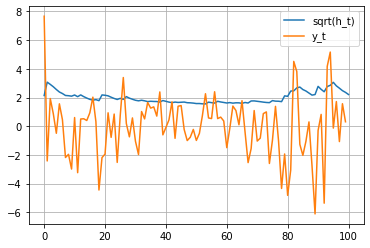

In [64]:
plt.plot(fvm.h ** .5, label='sqrt(h_t)')
plt.plot(train.values, label='y_t')

plt.legend()
plt.grid()
plt.show()

In [65]:
fvm.h

array([4.58784044, 9.4422688 , 8.5157479 , 7.57927839, 6.5580953 ,
       5.69155096, 5.19704772, 4.59723419, 4.5297512 , 4.39278773,
       4.74432821, 4.24862401, 4.77250743, 4.26094335, 3.8523765 ,
       3.51469073, 3.30886344, 3.43811854, 3.17715631, 4.75932932,
       4.66216042, 4.4927555 , 4.09321163, 3.74804436, 3.48194087,
       3.78225742, 3.49809571, 4.26574788, 3.8346964 , 3.53561579,
       3.27662157, 3.13897438, 3.28315637, 3.13909582, 2.95193947,
       3.02846488, 2.98442562, 2.97021977, 2.83826737, 3.20735576,
       3.01578432, 2.82994181, 2.69798961, 2.83813089, 2.75157463,
       2.79452251, 2.84050612, 2.69347777, 2.66197253, 2.59924066,
       2.49981029, 2.50472816, 2.44214963, 2.42161428, 2.82020526,
       2.70281532, 2.60429555, 3.02547456, 2.86277615, 2.74338418,
       2.62304386, 2.71764391, 2.59183747, 2.66935244, 2.66083964,
       2.54562017, 2.74112505, 2.62366428, 3.10003909, 3.11887002,
       3.02079535, 2.93058355, 2.82354199, 2.74565085, 2.70337

## `feed_daily_data`

In [66]:
n_test_small = 10
test_small = test.iloc[:n_test_small].copy()
input_cut = pd.concat([train, test_small]).copy()

data_to_cluster_test_1 = pd.Series(test_small.index.dayofweek + 1, index=test_small.index).copy()
data_to_cluster_test_2 = 'train'
data_to_cluster_test = [data_to_cluster_test_1, data_to_cluster_test_2]
# data_to_cluster = test_small.index.dayofweek + 1
# data_to_cluster = pd.Series(data_to_cluster, index=test_small.index)

In [67]:
data_to_cluster_test

[<DATE>
 2010-06-04    5
 2010-06-07    1
 2010-06-08    2
 2010-06-09    3
 2010-06-10    4
 2010-06-11    5
 2010-06-15    2
 2010-06-16    3
 2010-06-17    4
 2010-06-18    5
 Name: <DATE>, dtype: int64,
 'train']

In [68]:
fvm._membership_degrees_hist

[array([0.00425907, 0.24574093, 0.0127772 , 0.7372228 ], dtype=float128)]

In [69]:
%%time

fvm.feed_daily_data(test_small, data_to_cluster=data_to_cluster_test)

CPU times: user 3min 4s, sys: 5.31 s, total: 3min 9s
Wall time: 3min 13s


In [70]:
fvm.data_to_cluster

,<DATE>,log return
<DATE>,,
2010-01-11,1.0,7.668616
2010-01-12,2.0,-2.421124
2010-01-13,3.0,1.932676
2010-01-14,4.0,0.874942
2010-01-15,5.0,-0.491052
...,...,...
2010-06-11,5.0,-0.601688
2010-06-15,2.0,3.508624
2010-06-16,3.0,-0.205114


In [71]:
len(fvm._hist_output)

11

In [72]:
fvm.h

array([4.58784044, 9.28784561, 8.36345265, 7.43500871, 6.42867503,
       5.57647706, 5.08898536, 4.50088406, 4.43219517, 4.29659953,
       4.63682253, 4.15284014, 4.66157224, 4.16266148, 3.76476124,
       3.43635354, 3.23656857, 3.36287806, 3.10934294, 4.64895892,
       4.55312847, 4.38739755, 3.99817091, 3.66239262, 3.40390727,
       3.69663184, 3.42035154, 4.16751804, 3.74770391, 3.45684109,
       3.20528803, 3.07198478, 3.21286668, 3.07307406, 2.89144979,
       2.96644411, 2.92396342, 2.91048043, 2.78240709, 3.14181449,
       2.95535387, 2.77469858, 2.64664545, 2.78335843, 2.69931732,
       2.74131656, 2.78617743, 2.64320757, 2.61276521, 2.55194078,
       2.45544705, 2.46052311, 2.39987778, 2.38015372, 2.76811116,
       2.65365955, 2.5577451 , 2.96749666, 2.80880293, 2.69250034,
       2.57543921, 2.66759568, 2.5452189 , 2.62076297, 2.61250931,
       2.50045967, 2.69079077, 2.57643597, 3.03988837, 3.05772512,
       2.96191601, 2.87394454, 2.76974439, 2.69403334, 2.65304

In [73]:
_.shape

(111,)

In [74]:
fvm.data_to_cluster[-10:]

,<DATE>,log return
<DATE>,,
2010-06-04,5.0,-3.674357
2010-06-07,1.0,-1.126682
2010-06-08,2.0,-0.472658
2010-06-09,3.0,0.472658
2010-06-10,4.0,2.482080
2010-06-11,5.0,-0.601688
2010-06-15,2.0,3.508624
2010-06-16,3.0,-0.205114
2010-06-17,4.0,-0.018538


In [75]:
fvm.membership_degrees_hist

,0,1,2,3
<DATE>,,,,
2010-06-04,0.000000,0.000000,0.904971,0.095029
2010-06-07,0.980727,0.019273,0.000000,0.000000
2010-06-08,0.354609,0.395391,0.118203,0.131797
2010-06-09,0.061379,0.438621,0.061379,0.438621
2010-06-10,0.001408,0.248592,0.004223,0.745777
2010-06-11,0.000000,0.000000,0.019040,0.980960
2010-06-15,0.005331,0.744669,0.001777,0.248223
2010-06-16,0.002244,0.497756,0.002244,0.497756
2010-06-17,0.037887,0.212113,0.113661,0.636339


In [76]:
fvm._membership_degrees_hist

[array([0.00425907, 0.24574093, 0.0127772 , 0.7372228 ], dtype=float128),
 array([0.        , 0.        , 0.90497144, 0.09502856], dtype=float128),
 array([0.98072686, 0.01927314, 0.        , 0.        ], dtype=float128),
 array([0.35460874, 0.39539126, 0.11820291, 0.13179709], dtype=float128),
 array([0.06137925, 0.43862075, 0.06137925, 0.43862075], dtype=float128),
 array([0.00140782, 0.24859218, 0.00422347, 0.74577653], dtype=float128),
 array([0.        , 0.        , 0.01904009, 0.98095991], dtype=float128),
 array([0.00533063, 0.74466937, 0.00177688, 0.24822312], dtype=float128),
 array([0.00224402, 0.49775598, 0.00224402, 0.49775598], dtype=float128),
 array([0.03788685, 0.21211315, 0.11366056, 0.63633944], dtype=float128),
 array([0.        , 0.        , 0.06082466, 0.93917534], dtype=float128)]

In [77]:
fvm.hist_output

2010-06-04    4.888326
2010-06-07    6.097234
2010-06-08    5.309355
2010-06-09    4.524117
2010-06-10    3.889341
2010-06-11    4.157757
2010-06-15    3.682570
2010-06-16    4.624464
2010-06-17    4.092517
2010-06-18    3.646081
dtype: float128

In [78]:
test

<DATE>
2010-06-04   -3.674357
2010-06-07   -1.126682
2010-06-08   -0.472658
2010-06-09    0.472658
2010-06-10    2.482080
2010-06-11   -0.601688
2010-06-15    3.508624
2010-06-16   -0.205114
2010-06-17   -0.018538
2010-06-18    0.693539
Name: log return, dtype: float64

In [79]:
fvm.membership_degrees_current

array([0.        , 0.        , 0.06082466, 0.93917534], dtype=float128)

In [80]:
fvm.clusterization_parameters

[{'a': [1, 1], 'b': [1, 5], 'c': [1, 5], 'd': [5, 5], 'n_clusters': 2},
 {'centers': [-4.5, 2.5], 'variances': [7, 5], 'n_clusters': 2}]

In [81]:
fvm._parameters_hist

[{'alpha_0': array([0.01300959, 1.53008699, 1.30142911, 0.0250026 ], dtype=float128),
  'alpha': array([[0.09101356, 0.09101476, 0.09101359, 0.09101731]], dtype=float128),
  'beta': array([[0.80181758, 0.80182204, 0.80181669, 0.80183396]], dtype=float128)},
 {'alpha_0': array([1.76520343e-01, 1.67535625e+00, 1.74770540e-03, 3.23467582e+00],
        dtype=float128),
  'alpha': array([[0.06958596, 0.1403651 , 0.08224971, 0.08226174]], dtype=float128),
  'beta': array([[0.8367954 , 0.8367954 , 0.84194451, 0.84192648]], dtype=float128)},
 {'alpha_0': array([0.22005448, 6.6515782 , 0.00695044, 0.13447522]),
  'alpha': array([[0.08366705, 0.08366137, 0.11637558, 0.11637558]]),
  'beta': array([[0.8292855 , 0.82910224, 0.8367954 , 0.8367954 ]])},
 {'alpha_0': array([0.14983498, 0.57867526, 0.0018363 , 0.78201124], dtype=float128),
  'alpha': array([[0.08678008, 0.08672745, 0.08708627, 0.08707177]], dtype=float128),
  'beta': array([[0.81288893, 0.81294346, 0.81255965, 0.81258089]], dtype=floa

### Plots

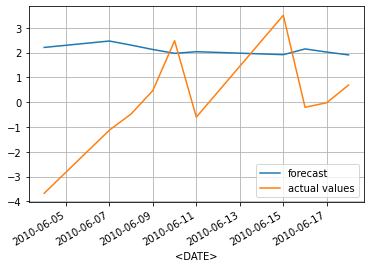

In [82]:
(fvm.hist_output ** .5).plot(label='forecast')
test_small.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

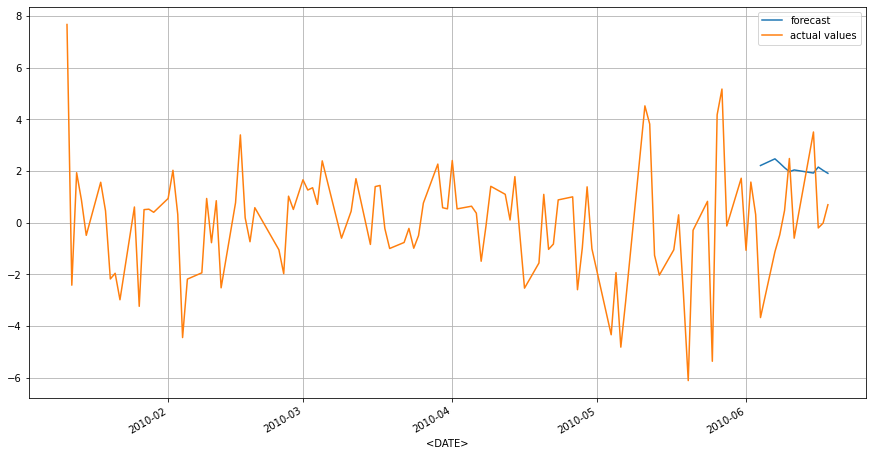

In [83]:
(fvm.hist_output ** .5).plot(label='forecast', figsize=(15, 8))
input_cut.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

### Errors

In [84]:
mean_squared_error(fvm.hist_output ** .5, test_small, squared=True)

7.8971032624259262637

In [85]:
mean_squared_error(fvm.hist_output ** .5, test_small, squared=False)

2.8101785107757703199

In [86]:
mean_absolute_percentage_error(fvm.hist_output ** .5, test_small)

1.1224425703803655029

# Model w/o seasoning

In [87]:
lower_bounds_2 = [0] * (1 + p + q) * n_clusters_2
upper_bounds_2 = [+np.inf] * n_clusters_2 + [1] * (p + q) * n_clusters_2
bounds_2 = (lower_bounds_2, upper_bounds_2)

In [88]:
alpha_0_ini_2 = np.array([garch_fitted.params.iloc[0] for _ in range(n_clusters_2)])
alpha_ini_2 = np.array([garch_fitted.params.iloc[1:(q + 1)].values for _ in range(n_clusters_2)])
beta_ini_2 = np.array([garch_fitted.params.iloc[(q + 1):].values for _ in range(n_clusters_2)])

In [89]:
parameters_ini_2 = {'alpha_0': alpha_0_ini_2, 'alpha': alpha_ini_2, 'beta': beta_ini_2}

In [90]:
local_method_parameters_2 = local_method_parameters.copy()
local_method_parameters_2['bounds'] = bounds_2
local_method_parameters_2['parameters_ini'] = parameters_ini_2

In [91]:
fvm_vanilla = FuzzyVolatilityModel(train,
                           clusterization_method=clusterization_methods[1],
                           clusterization_parameters=clusterization_parameters[1],
                           local_method=local_method,
                           local_method_parameters=local_method_parameters_2,
                           n_last_points_to_use_for_clustering=n_last_points_to_use_for_clustering[1],
                           data_to_cluster=data_to_cluster[1],
                           cluster_sets_conjunction=cluster_sets_conjunction)

## `fit`

In [92]:
%%time

fvm_vanilla.fit()

CPU times: user 5.23 s, sys: 178 ms, total: 5.41 s
Wall time: 5.44 s


In [93]:
n_last_points_to_use_for_clustering

[1, 2]

In [94]:
fvm_vanilla.alpha_0

array([0.0057277 , 0.41819605])

In [95]:
fvm_vanilla.alpha

array([[0.09101855, 0.09101855]])

In [96]:
fvm_vanilla.beta

array([[0.80179799, 0.80181739]])

In [97]:
garch_fitted.params

omega       0.176520
alpha[1]    0.116376
beta[1]     0.836795
Name: params, dtype: float64

In [98]:
fvm_vanilla._parameters_hist

[{'alpha_0': array([0.0057277 , 0.41819605]),
  'alpha': array([[0.09101855, 0.09101855]]),
  'beta': array([[0.80179799, 0.80181739]])}]

In [99]:
fvm_vanilla.membership_degrees_current

array([0.00031326, 0.01807474], dtype=float128)

In [100]:
fvm_vanilla.clusters_parameters_current

{'n_clusters': 2,
 'params by sets': [{'centers': [-4.5, 2.5],
   'variances': [7, 5],
   'n_clusters': 2}]}

In [101]:
data_to_cluster

[<DATE>
 2010-01-11    1
 2010-01-12    2
 2010-01-13    3
 2010-01-14    4
 2010-01-15    5
              ..
 2010-05-28    5
 2010-05-31    1
 2010-06-01    2
 2010-06-02    3
 2010-06-03    4
 Name: <DATE>, Length: 100, dtype: int64,
 'train']

In [102]:
fvm_vanilla._membership_degrees_hist

[array([0.00031326, 0.01807474], dtype=float128)]

In [103]:
fvm_vanilla.train_data

<DATE>
2010-01-11    7.668616
2010-01-12   -2.421124
2010-01-13    1.932676
2010-01-14    0.874942
2010-01-15   -0.491052
                ...   
2010-05-28   -0.129833
2010-05-31    1.718848
2010-06-01   -1.069901
2010-06-02    1.570084
2010-06-03    0.310364
Name: log return, Length: 100, dtype: float64

## `forecast`

In [104]:
fvm_vanilla.forecast()

In [105]:
fvm_vanilla.current_output

4.8881593737027278597

In [106]:
fvm_vanilla._hist_output

[4.8881593737027278597]

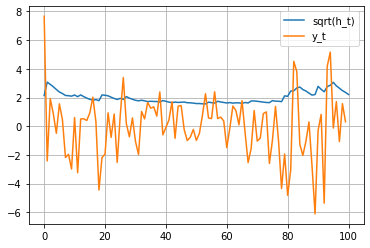

In [107]:
plt.plot(fvm_vanilla.h ** .5, label='sqrt(h_t)')
plt.plot(train.values, label='y_t')

plt.legend()
plt.grid()
plt.show()

In [108]:
fvm_vanilla.h

array([4.58784044, 9.44236721, 8.51575658, 7.57922368, 6.55799684,
       5.69143038, 5.19692551, 4.59711312, 4.52964802, 4.39269807,
       4.74426105, 4.24855357, 4.7724607 , 4.2608887 , 3.85232253,
       3.51464268, 3.30882614, 3.43809891, 3.17714134, 4.75935968,
       4.6621765 , 4.49275951, 4.09320269, 3.74802998, 3.48192707,
       3.78225863, 3.4980937 , 4.26576831, 3.83470211, 3.53561657,
       3.27662209, 3.13897973, 3.28317286, 3.13911377, 2.95195904,
       3.02849311, 2.98445752, 2.97025566, 2.8383041 , 3.20740503,
       3.01582827, 2.82998342, 2.69803225, 2.83818138, 2.75162528,
       2.79457685, 2.84056307, 2.6935323 , 2.66202895, 2.59929824,
       2.49986861, 2.50479023, 2.44221323, 2.42168059, 2.82028284,
       2.70288719, 2.60436437, 3.02555289, 2.86284573, 2.7434492 ,
       2.62310634, 2.71771005, 2.59190098, 2.66941934, 2.6609067 ,
       2.54568517, 2.74119609, 2.62373166, 3.10011726, 3.11894262,
       3.02086081, 2.9306444 , 2.82359963, 2.74570756, 2.70343

## `feed_daily_data`

In [109]:
# n_test_small = 10
# test_small = test.iloc[:n_test_small].copy()
# input_cut = pd.concat([train, test_small]).copy()

# data_to_cluster_test_1 = pd.Series(test_small.index.dayofweek + 1, index=test_small.index).copy()
# data_to_cluster_test_2 = 'train'
# data_to_cluster_test = [data_to_cluster_test_1, data_to_cluster_test_2]

In [110]:
%%time

fvm_vanilla.feed_daily_data(test_small, data_to_cluster=data_to_cluster_test_2)

CPU times: user 1min 12s, sys: 2.3 s, total: 1min 14s
Wall time: 1min 14s


In [111]:
fvm_vanilla.data_to_cluster

<DATE>
2010-01-11    7.668616
2010-01-12   -2.421124
2010-01-13    1.932676
2010-01-14    0.874942
2010-01-15   -0.491052
                ...   
2010-06-11   -0.601688
2010-06-15    3.508624
2010-06-16   -0.205114
2010-06-17   -0.018538
2010-06-18    0.693539
Name: log return, Length: 110, dtype: float64

In [112]:
len(fvm_vanilla._hist_output)

11

In [113]:
fvm_vanilla.h

array([4.58784044, 9.28738653, 8.3621622 , 7.43325235, 6.4267534 ,
       5.57462496, 5.08733698, 4.49951364, 4.43112329, 4.29578797,
       4.63620214, 4.1523799 , 4.66124762, 4.16243414, 3.76470943,
       3.4365212 , 3.23697015, 3.36347812, 3.11011173, 4.64974239,
       4.55375153, 4.38791968, 3.99866976, 3.66295152, 3.40457905,
       3.69739588, 3.4211819 , 4.16836112, 3.74851007, 3.45769557,
       3.20624005, 3.07305755, 3.21403806, 3.07432143, 2.8927922 ,
       2.96787668, 2.92546348, 2.91204084, 2.78402989, 3.14346726,
       2.95700645, 2.77639064, 2.6484029 , 2.78516999, 2.70116427,
       2.74319765, 2.78807652, 2.64512974, 2.61472567, 2.55394142,
       2.45749645, 2.46262243, 2.40202237, 2.38234363, 2.77030181,
       2.65581622, 2.55989742, 2.96961681, 2.81086452, 2.6945451 ,
       2.57749565, 2.66966627, 2.54730189, 2.62286295, 2.61461478,
       2.50258146, 2.69292025, 2.57856032, 3.04197686, 3.05972853,
       2.96385855, 2.87585825, 2.77165556, 2.69596215, 2.65499

In [114]:
_.shape

(111,)

In [115]:
fvm_vanilla.data_to_cluster[-10:]

<DATE>
2010-06-04   -3.674357
2010-06-07   -1.126682
2010-06-08   -0.472658
2010-06-09    0.472658
2010-06-10    2.482080
2010-06-11   -0.601688
2010-06-15    3.508624
2010-06-16   -0.205114
2010-06-17   -0.018538
2010-06-18    0.693539
Name: log return, dtype: float64

In [116]:
fvm_vanilla.membership_degrees_hist

,0,1
<DATE>,,
2010-06-04,0.004147,0.000435
2010-06-07,0.009607,0.000189
2010-06-08,0.003167,0.003531
2010-06-09,0.001220,0.008721
2010-06-10,0.000120,0.021103
2010-06-11,0.000236,0.012163
2010-06-15,0.000079,0.010986
2010-06-16,0.000062,0.013831
2010-06-17,0.001450,0.008120


In [117]:
fvm_vanilla.hist_output

2010-06-04    4.888159
2010-06-07    6.097066
2010-06-08    5.310522
2010-06-09    4.523613
2010-06-10    3.889478
2010-06-11    4.157644
2010-06-15    3.682655
2010-06-16    4.624539
2010-06-17    4.092554
2010-06-18    3.646428
dtype: float128

In [118]:
test

<DATE>
2010-06-04   -3.674357
2010-06-07   -1.126682
2010-06-08   -0.472658
2010-06-09    0.472658
2010-06-10    2.482080
2010-06-11   -0.601688
2010-06-15    3.508624
2010-06-16   -0.205114
2010-06-17   -0.018538
2010-06-18    0.693539
Name: log return, dtype: float64

In [119]:
fvm_vanilla.membership_degrees_current

array([0.00078883, 0.01218014], dtype=float128)

In [120]:
fvm_vanilla.clusterization_parameters

{'centers': [-4.5, 2.5], 'variances': [7, 5], 'n_clusters': 2}

In [121]:
fvm_vanilla._parameters_hist

[{'alpha_0': array([0.0057277 , 0.41819605]),
  'alpha': array([[0.09101855, 0.09101855]]),
  'beta': array([[0.80179799, 0.80181739]])},
 {'alpha_0': array([0.29486296, 0.44271091]),
  'alpha': array([[0.08223756, 0.08212994]]),
  'beta': array([[0.84196163, 0.8420965 ]])},
 {'alpha_0': array([0.18478127, 8.42622788]),
  'alpha': array([[0.08362359, 0.08362398]]),
  'beta': array([[0.82941984, 0.82928645]])},
 {'alpha_0': array([8.15013020e-01, 4.73338541e-05], dtype=float128),
  'alpha': array([[0.08669119, 0.08702428]], dtype=float128),
  'beta': array([[0.81276828, 0.81275508]], dtype=float128)},
 {'alpha_0': array([0.06086538, 0.47353231]),
  'alpha': array([[0.09088587, 0.09088773]]),
  'beta': array([[0.79642389, 0.79652146]])},
 {'alpha_0': array([0.01873716, 0.40717408]),
  'alpha': array([[0.08852096, 0.08852043]]),
  'beta': array([[0.80477448, 0.80485765]])},
 {'alpha_0': array([0.0106083 , 0.43298488]),
  'alpha': array([[0.09114333, 0.09114811]]),
  'beta': array([[0.7949

### Plots

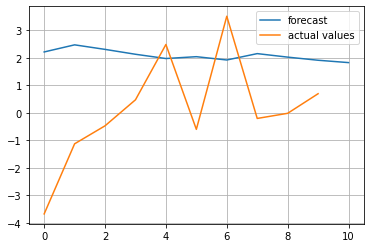

In [122]:
plt.plot((np.array(fvm_vanilla._hist_output) ** .5), label='forecast')
plt.plot(test_small.values, label='actual values')

plt.legend()
plt.grid()
plt.show()

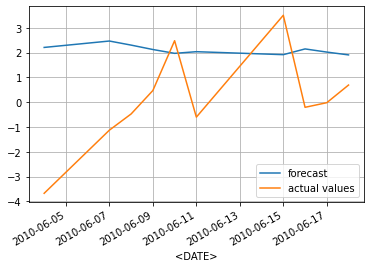

In [123]:
(fvm_vanilla.hist_output ** .5).plot(label='forecast')
test_small.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

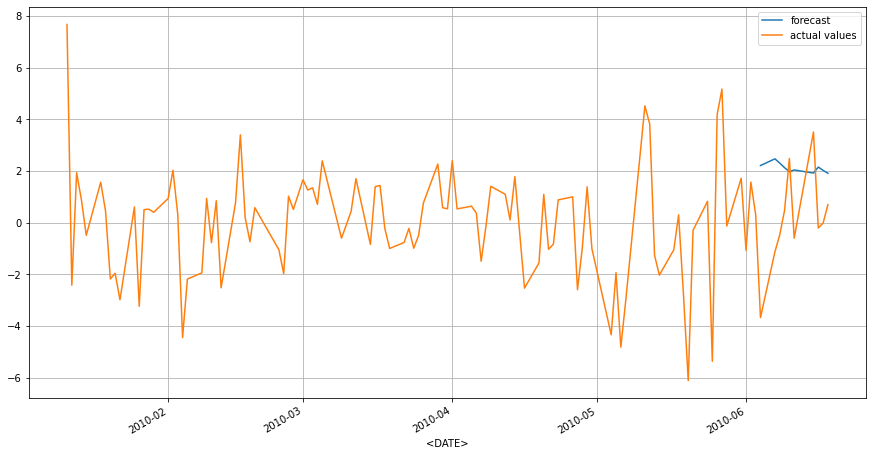

In [124]:
(fvm_vanilla.hist_output ** .5).plot(label='forecast', figsize=(15, 8))
input_cut.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

### Errors

In [125]:
mean_squared_error(fvm_vanilla.hist_output ** .5, test_small, squared=True)

7.897144479490540774

In [126]:
_ / mean_squared_error(fvm.hist_output ** .5, test_small, squared=True)

1.0000052192637280836

In [127]:
(_ - 1) * 100

0.00052192637280836342087

In [128]:
mean_squared_error(fvm_vanilla.hist_output ** .5, test_small, squared=False)

2.8101858442975868023

In [129]:
mean_absolute_percentage_error(fvm_vanilla.hist_output ** .5, test_small)

1.1224402800376515556

## Diff w/ seasonal model

In [130]:
fvm.h - fvm_vanilla.h

array([ 0.00000000e+00,  4.59071811e-04,  1.29045193e-03,  1.75636172e-03,
        1.92163107e-03,  1.85209945e-03,  1.64838122e-03,  1.37042393e-03,
        1.07187730e-03,  8.11555925e-04,  6.20391389e-04,  4.60233021e-04,
        3.24623422e-04,  2.27346708e-04,  5.18157350e-05, -1.67665650e-04,
       -4.01581240e-04, -6.00056254e-04, -7.68792343e-04, -7.83472320e-04,
       -6.23059338e-04, -5.22123980e-04, -4.98857646e-04, -5.58898172e-04,
       -6.71779828e-04, -7.64043466e-04, -8.30357202e-04, -8.43082097e-04,
       -8.06157454e-04, -8.54486403e-04, -9.52020769e-04, -1.07276701e-03,
       -1.17138915e-03, -1.24737208e-03, -1.34240666e-03, -1.43257496e-03,
       -1.50005980e-03, -1.56040609e-03, -1.62280456e-03, -1.65277186e-03,
       -1.65258793e-03, -1.69205827e-03, -1.75745290e-03, -1.81155391e-03,
       -1.84694705e-03, -1.88108803e-03, -1.89908736e-03, -1.92216241e-03,
       -1.96046153e-03, -2.00064638e-03, -2.04940451e-03, -2.09931649e-03,
       -2.14459241e-03, -

In [131]:
_.mean()

-0.0005371182899514067328

## Same data fed to GARCH(1, 1)

### No retraining

In [132]:
model = arch_model(train,
                   mean=local_method_parameters['mean'],
                   vol='GARCH', p=local_method_parameters['p'],
                   q=local_method_parameters['q'],
                   dist=local_method_parameters['dist'])

In [133]:
model.volatility

GARCH(p: 1, q: 1), id: 0x7fcbbfb11640

In [134]:
fitted = model.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 299.2568988057981
Iteration:      2,   Func. Count:     11,   Neg. LLF: 218.16618783247299
Iteration:      3,   Func. Count:     19,   Neg. LLF: 216.13038589493937
Iteration:      4,   Func. Count:     25,   Neg. LLF: 210.3506174261232
Iteration:      5,   Func. Count:     30,   Neg. LLF: 210.03006916424286
Iteration:      6,   Func. Count:     34,   Neg. LLF: 210.02991627546388
Iteration:      7,   Func. Count:     38,   Neg. LLF: 210.02991515111927
Iteration:      8,   Func. Count:     41,   Neg. LLF: 210.0299151508097
Optimization terminated successfully    (Exit mode 0)
            Current function value: 210.02991515111927
            Iterations: 8
            Function evaluations: 41
            Gradient evaluations: 8


In [135]:
fitted.summary

<bound method ARCHModelResult.summary of                        Zero Mean - GARCH Model Results                        
Dep. Variable:             log return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.010
Vol Model:                      GARCH   Log-Likelihood:               -210.030
Distribution:                  Normal   AIC:                           426.060
Method:            Maximum Likelihood   BIC:                           433.875
                                        No. Observations:                  100
Date:                Sun, Sep 04 2022   Df Residuals:                      100
Time:                        23:24:36   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1765  

In [136]:
fitted.params

omega       0.176520
alpha[1]    0.116376
beta[1]     0.836795
Name: params, dtype: float64

In [137]:
fvm.alpha_0

array([0.17652034, 1.83264352, 0.1821474 , 0.42230558], dtype=float128)

In [138]:
fvm.alpha

array([[0.51760574, 0.15731828, 0.08854221, 0.08853695]], dtype=float128)

In [139]:
fvm.beta

array([[0.8367954 , 0.8367954 , 0.80071355, 0.80069742]], dtype=float128)

In [140]:
forecast = fitted.forecast(reindex=False, horizon=1)

In [141]:
forecast_variance = forecast.variance.iloc[0]

In [142]:
forecast_variance

h.1    5.947653
Name: 2010-06-03 00:00:00, dtype: float64

In [143]:
simple_garch_forecasts = garch_fitted.forecast(horizon=n_test, reindex=False).variance.iloc[0].values

In [144]:
mean_squared_error(simple_garch_forecasts, test_small ** 2, squared=True)

28.996156386614256

### With retraining

In [145]:
def calc_vanilla_garch_wr_mse(info, data, garch_mean, garch_vol, garch_dist):
    train_size = info.loc['Train size']
    test_size = info.loc['Test size']
    p = info.loc['p']
    q = info.loc['q']
    
    train = data[info.loc['Start date']:].iloc[:train_size]
    test = data[info.loc['Start date']:].iloc[train_size:(train_size + test_size)]
    
    forecast = calculate_retraining_garch_forecasts(train, test,
                                                    mean=garch_mean,
                                                    vol=garch_vol,
                                                    p=p,
                                                    q=q,
                                                    dist=garch_dist)
    
    mse = mean_squared_error(forecast, test ** 2, squared=True)
    
    return mse

# Bollocks

In [146]:
from multiprocessing import Pool

In [147]:
def f(length):
    arr = []
    for i in range(int(length)):
        arr.append(i + 1)
    return arr

In [148]:
%%time

arr = f(1e5)

CPU times: user 11.5 ms, sys: 3.13 ms, total: 14.6 ms
Wall time: 14.4 ms
